#**Fake News Detection**

In [35]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')
valid_data = pd.read_csv('/content/valid.csv')


In [37]:
print(train_data.columns)
print(test_data.columns)
print(valid_data.columns)

Index(['Statement', 'Label'], dtype='object')
Index(['Statement', 'Label'], dtype='object')
Index(['Statement', 'Label'], dtype='object')


###**Data Prep**

In [38]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    return text


In [45]:
# Apply preprocessing
train_data['cleaned_text'] = train_data['Statement'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['Statement'].apply(preprocess_text)
valid_data['cleaned_text'] = valid_data['Statement'].apply(preprocess_text)

# Handle missing values
train_data['cleaned_text'].fillna('', inplace=True)
test_data['cleaned_text'].fillna('', inplace=True)
valid_data['cleaned_text'].fillna('', inplace=True)

# Ensure text columns are of string type
train_data['cleaned_text'] = train_data['cleaned_text'].astype(str)
test_data['cleaned_text'] = test_data['cleaned_text'].astype(str)
valid_data['cleaned_text'] = valid_data['cleaned_text'].astype(str)


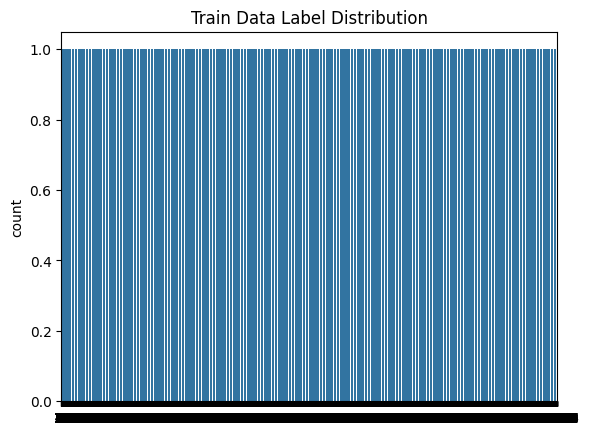

Statement       0
Label           0
cleaned_text    0
dtype: int64


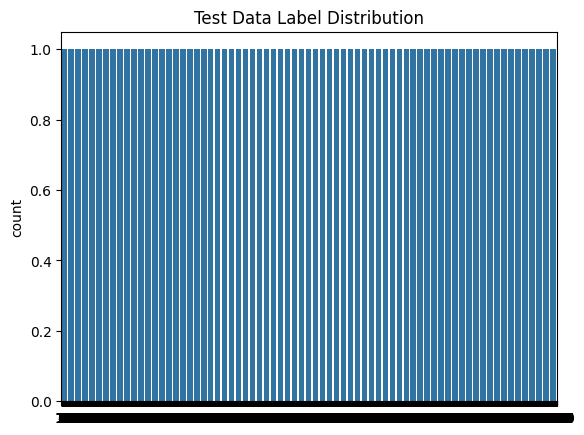

Statement       0
Label           0
cleaned_text    0
dtype: int64


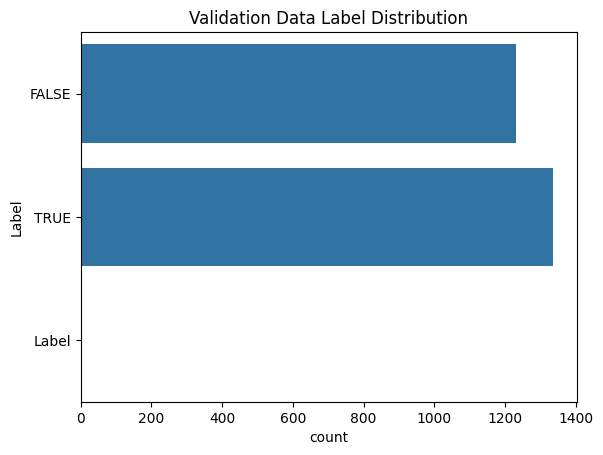

Statement       0
Label           2
cleaned_text    0
dtype: int64


In [40]:
# Exploratory Data Analysis
def eda(data, title):
    # Response variable distribution
    sns.countplot(data['Label'])
    plt.title(f'{title} Label Distribution')
    plt.show()
    # Check for null values
    print(data.isnull().sum())

eda(train_data, 'Train Data')
eda(test_data, 'Test Data')
eda(valid_data, 'Validation Data')

In [41]:
# Save cleaned data
train_data.to_csv('cleaned_train.csv', index=False)
test_data.to_csv('cleaned_test.csv', index=False)
valid_data.to_csv('cleaned_valid.csv', index=False)

###**Feature Selection**

In [46]:
# FeatureSelection.py

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Load cleaned data
train_data = pd.read_csv('cleaned_train.csv')
test_data = pd.read_csv('cleaned_test.csv')
valid_data = pd.read_csv('cleaned_valid.csv')

# Ensure there are no missing values and text columns are of string type
train_data['cleaned_text'].fillna('', inplace=True)
test_data['cleaned_text'].fillna('', inplace=True)
valid_data['cleaned_text'].fillna('', inplace=True)

train_data['cleaned_text'] = train_data['cleaned_text'].astype(str)
test_data['cleaned_text'] = test_data['cleaned_text'].astype(str)
valid_data['cleaned_text'] = valid_data['cleaned_text'].astype(str)

# Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
X_test = vectorizer.transform(test_data['cleaned_text'])
X_valid = vectorizer.transform(valid_data['cleaned_text'])

y_train = train_data['Label']
y_test = test_data['Label']
y_valid = valid_data['Label']

# Save features
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump((X_train, y_train), 'train_features.pkl')
joblib.dump((X_test, y_test), 'test_features.pkl')
joblib.dump((X_valid, y_valid), 'valid_features.pkl')


['valid_features.pkl']

In [49]:
# Load features
X_train, y_train = joblib.load('train_features.pkl')
X_test, y_test = joblib.load('test_features.pkl')
X_valid, y_valid = joblib.load('valid_features.pkl')

Naive Bayes Results:
Accuracy: 0.613484907879263
              precision    recall  f1-score   support

       False       0.61      0.42      0.50      1169
        True       0.61      0.78      0.69      1382

    accuracy                           0.61      2551
   macro avg       0.61      0.60      0.59      2551
weighted avg       0.61      0.61      0.60      2551



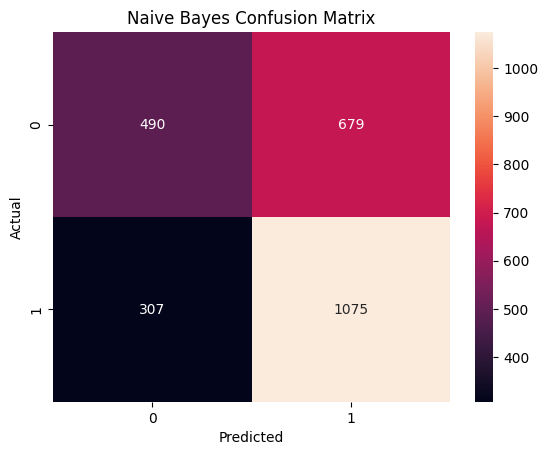

In [50]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Logistic Regression Results:
Accuracy: 0.6170129361034888
              precision    recall  f1-score   support

       False       0.61      0.46      0.52      1169
        True       0.62      0.75      0.68      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.60      2551
weighted avg       0.62      0.62      0.61      2551



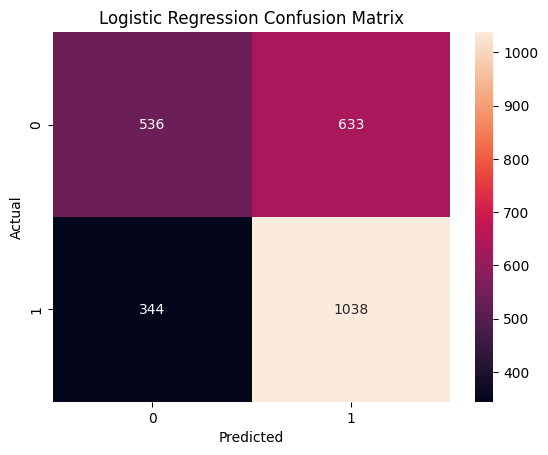

In [51]:
# Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Random Forest Results:
Accuracy: 0.6181889455115641
              precision    recall  f1-score   support

       False       0.62      0.44      0.51      1169
        True       0.62      0.77      0.69      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.60      0.60      2551
weighted avg       0.62      0.62      0.61      2551



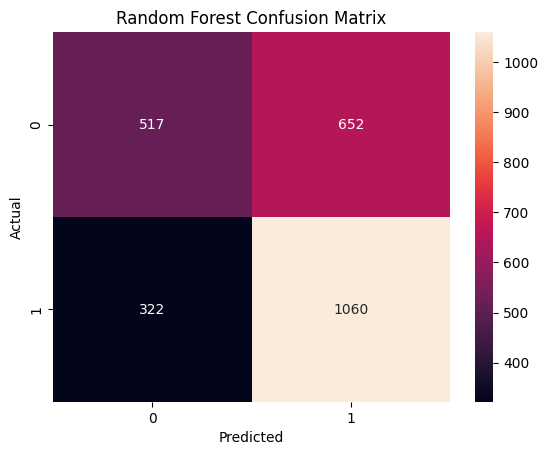

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



SVC Results:
Accuracy: 0.6201489611916895
              precision    recall  f1-score   support

       False       0.62      0.44      0.51      1169
        True       0.62      0.77      0.69      1382

    accuracy                           0.62      2551
   macro avg       0.62      0.61      0.60      2551
weighted avg       0.62      0.62      0.61      2551



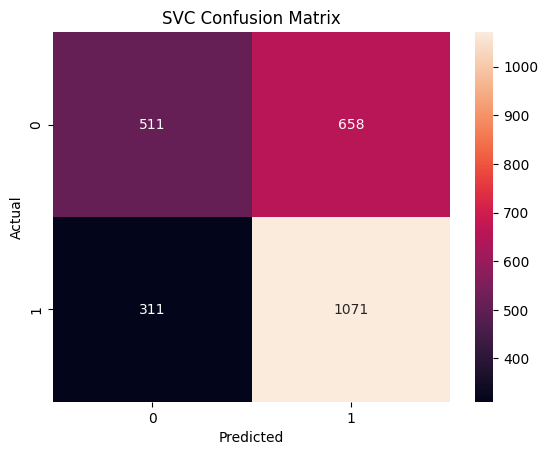

In [53]:
# SVC Model
svc_model = SVC()
svc_model.fit(X_train, y_train)

# Predictions
y_pred_svc = svc_model.predict(X_test)

# Evaluation
print("\nSVC Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.title('SVC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


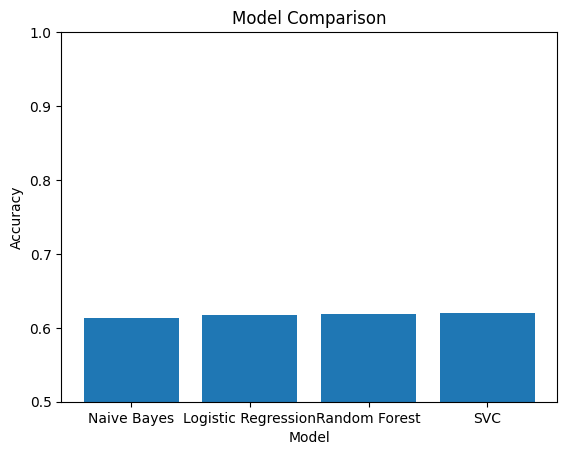


Naive Bayes Classification Report:
Accuracy: 0.6135
              precision    recall  f1-score      support
False          0.614806  0.419162  0.498474  1169.000000
True           0.612885  0.777858  0.685587  1382.000000
accuracy       0.613485  0.613485  0.613485     0.613485
macro avg      0.613845  0.598510  0.592030  2551.000000
weighted avg   0.613765  0.613485  0.599842  2551.000000

Logistic Regression Classification Report:
Accuracy: 0.6170
              precision    recall  f1-score      support
False          0.609091  0.458512  0.523182  1169.000000
True           0.621185  0.751085  0.679987  1382.000000
accuracy       0.617013  0.617013  0.617013     0.617013
macro avg      0.615138  0.604798  0.601584  2551.000000
weighted avg   0.615643  0.617013  0.608131  2551.000000

Random Forest Classification Report:
Accuracy: 0.6182
              precision    recall  f1-score      support
False          0.616210  0.442258  0.514940  1169.000000
True           0.619159  0.767004

In [54]:
# Model Comparison
models = [
    ('Naive Bayes', nb_model),
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('SVC', svc_model)
]

results = []
for name, model in models:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append((name, accuracy, report))

# Visualize Comparison
model_names = [result[0] for result in results]
accuracies = [result[1] for result in results]

plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0.5, 1.0)  # Set y-axis limits for better visualization
plt.show()

# Print Classification Reports
for name, accuracy, report in results:
    print(f"\n{name} Classification Report:")
    print(f"Accuracy: {accuracy:.4f}")
    print(pd.DataFrame(report).transpose())

# Find Best Model
best_model_name, best_accuracy, _ = max(results, key=lambda x: x[1])
print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")


In [60]:
# Save the best model
joblib.dump(svc_model, 'best_model.pkl') # replace rf_model with the variable holding the best model


['best_model.pkl']

In [61]:
# predict if news is fake or not using  'best_model.pkl'

# Load the best model
best_model = joblib.load('best_model.pkl')

# Load the vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_news(text):
  # Preprocess the input text
  cleaned_text = preprocess_text(text)

  # Vectorize the preprocessed text
  text_vectorized = vectorizer.transform([cleaned_text])

  # Make the prediction
  prediction = best_model.predict(text_vectorized)[0]

  # Interpret the prediction
  if prediction == 0:
    return "The news is likely real."
  else:
    return "The news is likely fake."

# Example usage
news_article = "Donald Trump won the 2020 presidential election."
prediction_result = predict_news(news_article)
print(prediction_result)


The news is likely fake.
